# EDA

In [1]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

---
# Part 1: MOT20Det Dataset Analysis
---

## 1.1 Load MOT20Det Dataset

In [2]:
def load_mot20_annotations(data_dir='../data/MOT20Det'):
    """
    Load MOT20 annotations from gt.txt files.
    Format: frame, id, bb_left, bb_top, bb_width, bb_height, conf, class, visibility
    """
    annotations = []
    data_path = Path(data_dir)
    
    for split in ['train', 'test']:
        split_path = data_path / split
        if not split_path.exists():
            continue
            
        for seq_dir in split_path.iterdir():
            if not seq_dir.is_dir():
                continue
                
            gt_file = seq_dir / 'gt' / 'gt.txt'
            if gt_file.exists():
                df = pd.read_csv(gt_file, header=None, 
                               names=['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 
                                     'conf', 'class', 'visibility'])
                df['sequence'] = seq_dir.name
                df['split'] = split
                annotations.append(df)
    
    return pd.concat(annotations, ignore_index=True)

mot20_df = load_mot20_annotations()

# Calculate additional metrics
mot20_df['center_x'] = mot20_df['bb_left'] + mot20_df['bb_width'] / 2
mot20_df['center_y'] = mot20_df['bb_top'] + mot20_df['bb_height'] / 2
mot20_df['aspect_ratio'] = mot20_df['bb_width'] / mot20_df['bb_height']
mot20_df['area'] = mot20_df['bb_width'] * mot20_df['bb_height']

print(f"MOT20Det Total annotations: {len(mot20_df):,}")
print(f"MOT20Det Sequences: {mot20_df['sequence'].nunique()}")
print(f"MOT20Det Unique IDs (tracks): {mot20_df['id'].nunique():,}")
mot20_df.head()

MOT20Det Total annotations: 1,336,920
MOT20Det Sequences: 4
MOT20Det Unique IDs (tracks): 1,211


,frame,id,bb_left,bb_top,bb_width,bb_height,conf,class,visibility,sequence,split,center_x,center_y,aspect_ratio,area
0,695,1,1127,817,45,62,1,1,1.0,MOT20-03,train,1149.5,848.0,0.725806,2790
1,696,1,1124,815,47,64,1,1,1.0,MOT20-03,train,1147.5,847.0,0.734375,3008
2,697,1,1122,813,48,66,1,1,1.0,MOT20-03,train,1146.0,846.0,0.727273,3168
3,698,1,1120,811,49,68,1,1,1.0,MOT20-03,train,1144.5,845.0,0.720588,3332
4,699,1,1118,809,50,70,1,1,1.0,MOT20-03,train,1143.0,844.0,0.714286,3500


## 1.2 MOT20Det Basic Statistics

In [3]:
print("="*80)
print("MOT20Det Statistics")
print("="*80)
print(mot20_df[['bb_width', 'bb_height', 'aspect_ratio', 'area', 'visibility']].describe())

print("\n" + "="*80)
print("Sequence Statistics")
print("="*80)
seq_stats = mot20_df.groupby('sequence').agg({
    'frame': 'nunique',
    'id': 'nunique',
    'bb_width': 'count'
}).rename(columns={'frame': 'num_frames', 'id': 'num_tracks', 'bb_width': 'num_detections'})
print(seq_stats)

MOT20Det Statistics
           bb_width     bb_height  aspect_ratio          area    visibility
count  1.336920e+06  1.336920e+06  1.336920e+06  1.336920e+06  1.336920e+06
mean   6.381840e+01  1.403452e+02  9.303509e-01  9.939311e+03  5.654351e-01
std    3.372145e+01  6.081982e+01  1.013191e+01  1.305196e+04  3.199242e-01
min    1.000000e+00  2.000000e+00  6.622517e-03  2.800000e+01  0.000000e+00
25%    4.900000e+01  1.070000e+02  3.904110e-01  5.280000e+03  2.979000e-01
50%    6.000000e+01  1.400000e+02  4.304636e-01  8.246000e+03  5.547800e-01
75%    7.000000e+01  1.640000e+02  4.857143e-01  1.135200e+04  8.750000e-01
max    5.050000e+02  8.540000e+02  2.505000e+02  4.095550e+05  1.000000e+00

Sequence Statistics
          num_frames  num_tracks  num_detections
sequence                                        
MOT20-01         429          90           26647
MOT20-02        2782         296          202215
MOT20-03        2405         735          356728
MOT20-05        3315        12

## 1.3 MOT20Det Visibility/Occlusion Analysis

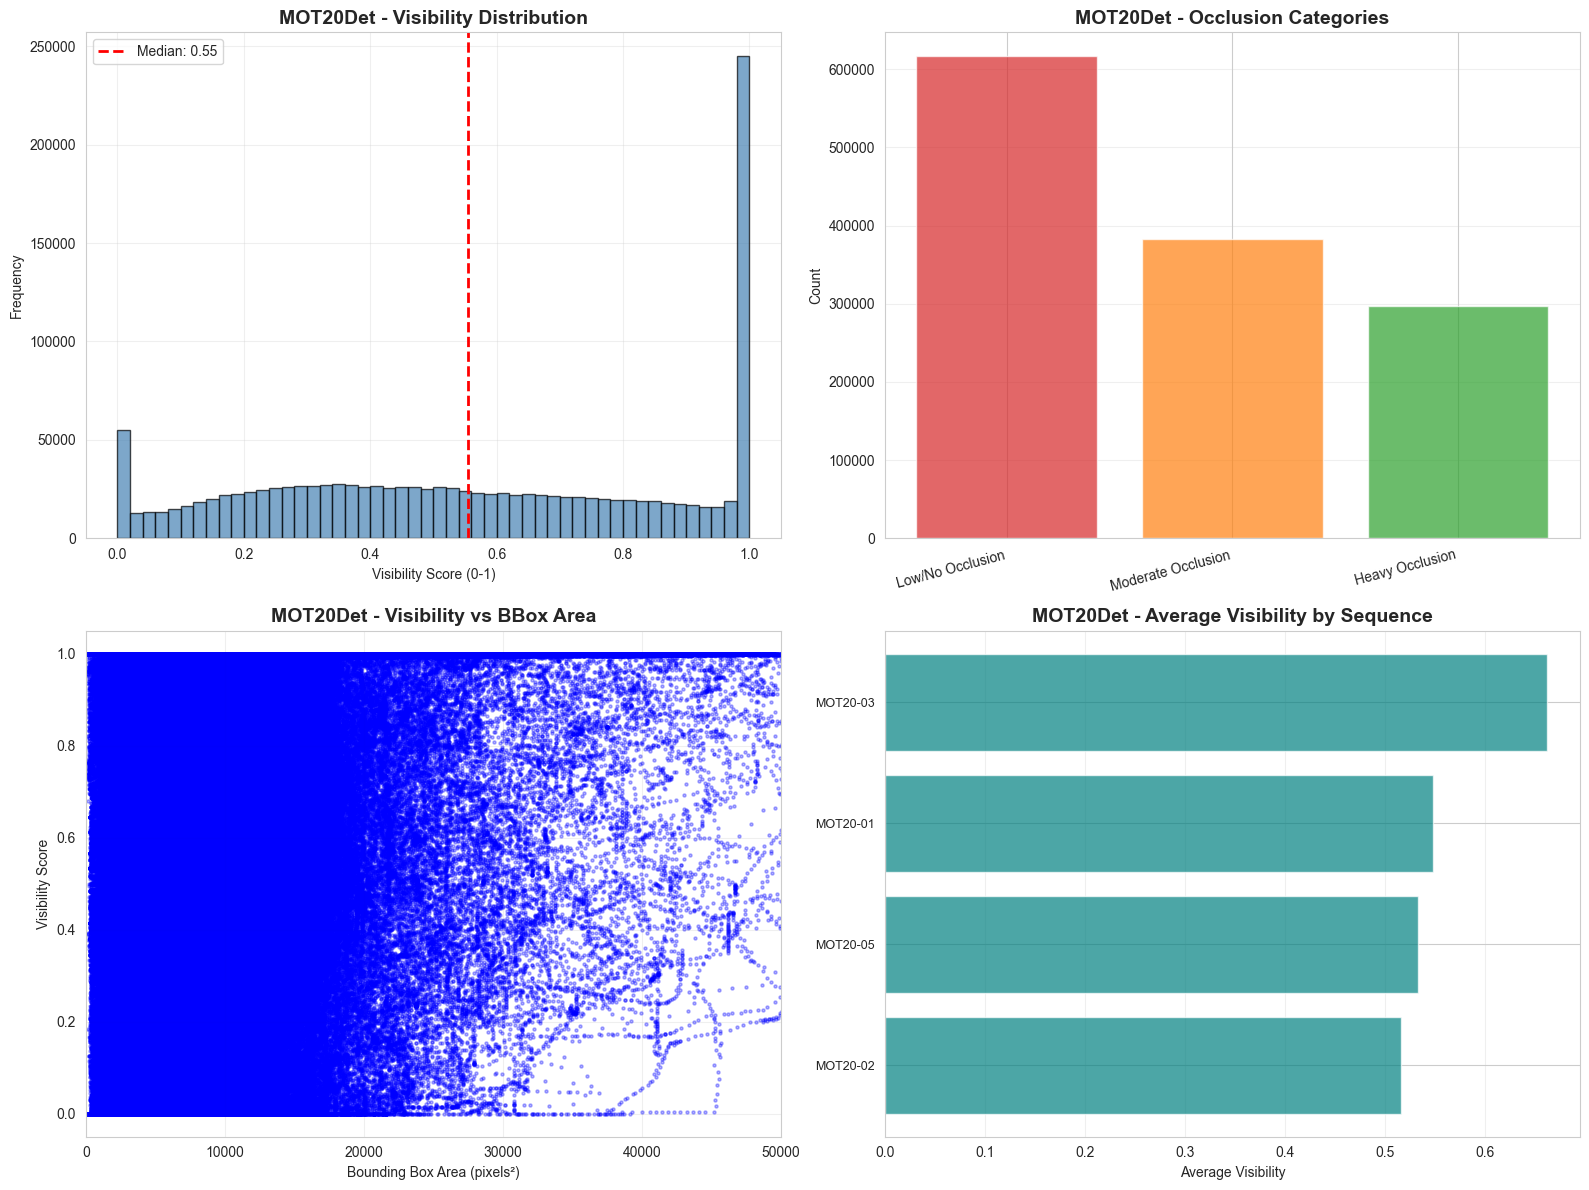

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Visibility distribution histogram
axes[0, 0].hist(mot20_df['visibility'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('MOT20Det - Visibility Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Visibility Score (0-1)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(mot20_df['visibility'].median(), color='red', linestyle='--', 
                   linewidth=2, label=f'Median: {mot20_df["visibility"].median():.2f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Occlusion categories
mot20_df['occlusion_level'] = pd.cut(mot20_df['visibility'], 
                                      bins=[0, 0.3, 0.6, 1.0], 
                                      labels=['Heavy Occlusion', 'Moderate Occlusion', 'Low/No Occlusion'])
occlusion_counts = mot20_df['occlusion_level'].value_counts()
axes[0, 1].bar(range(len(occlusion_counts)), occlusion_counts.values, 
               color=['#d62728', '#ff7f0e', '#2ca02c'], alpha=0.7)
axes[0, 1].set_xticks(range(len(occlusion_counts)))
axes[0, 1].set_xticklabels(occlusion_counts.index, rotation=15, ha='right')
axes[0, 1].set_title('MOT20Det - Occlusion Categories', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Count')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Visibility vs BBox size
axes[1, 0].scatter(mot20_df['area'], mot20_df['visibility'], alpha=0.3, s=5, c='blue')
axes[1, 0].set_title('MOT20Det - Visibility vs BBox Area', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Bounding Box Area (pixels²)')
axes[1, 0].set_ylabel('Visibility Score')
axes[1, 0].set_xlim(0, 50000)
axes[1, 0].grid(True, alpha=0.3)

# Visibility by sequence
seq_visibility = mot20_df.groupby('sequence')['visibility'].mean().sort_values()
axes[1, 1].barh(range(len(seq_visibility)), seq_visibility.values, color='teal', alpha=0.7)
axes[1, 1].set_yticks(range(len(seq_visibility)))
axes[1, 1].set_yticklabels(seq_visibility.index, fontsize=9)
axes[1, 1].set_title('MOT20Det - Average Visibility by Sequence', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Average Visibility')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 1.4 MOT20Det Tracking Analysis

In [5]:
# Track length analysis
track_lengths = mot20_df.groupby(['sequence', 'id']).size().reset_index(name='track_length')

print(f"\nTotal number of tracks: {len(track_lengths):,}")
print(f"Tracks with >100 frames: {(track_lengths['track_length'] > 100).sum():,}")
print(f"Tracks with <10 frames: {(track_lengths['track_length'] < 10).sum():,}")


Total number of tracks: 2,332
Tracks with >100 frames: 2,038
Tracks with <10 frames: 30


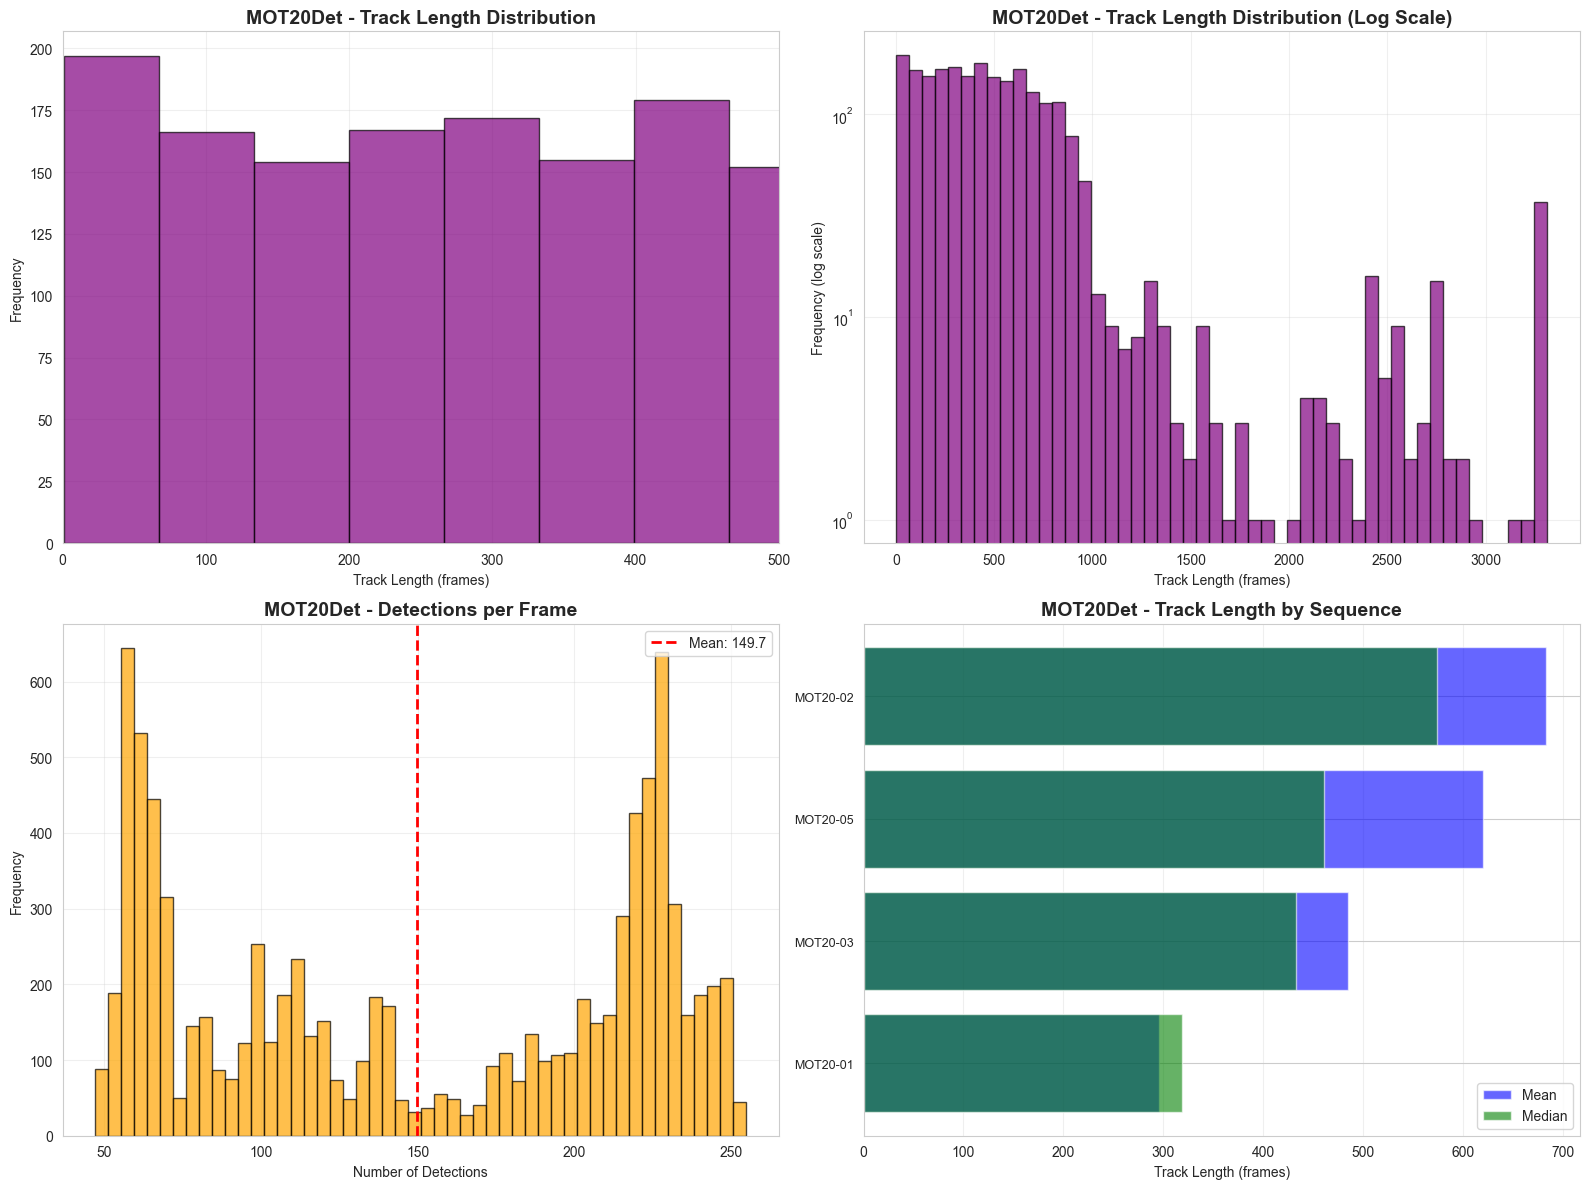

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Track length distribution
axes[0, 0].hist(track_lengths['track_length'], bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('MOT20Det - Track Length Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Track Length (frames)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_xlim(0, 500)
axes[0, 0].grid(True, alpha=0.3)

# Track length distribution (log scale)
axes[0, 1].hist(track_lengths['track_length'], bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('MOT20Det - Track Length Distribution (Log Scale)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Track Length (frames)')
axes[0, 1].set_ylabel('Frequency (log scale)')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# Detections per frame
detections_per_frame = mot20_df.groupby(['sequence', 'frame']).size().reset_index(name='num_detections')
axes[1, 0].hist(detections_per_frame['num_detections'], bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('MOT20Det - Detections per Frame', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Detections')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(detections_per_frame['num_detections'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean: {detections_per_frame["num_detections"].mean():.1f}')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Track length by sequence
seq_track_stats = track_lengths.groupby('sequence')['track_length'].agg(['mean', 'median', 'max']).sort_values('mean')
x_pos = np.arange(len(seq_track_stats))
axes[1, 1].barh(x_pos, seq_track_stats['mean'], alpha=0.6, label='Mean', color='blue')
axes[1, 1].barh(x_pos, seq_track_stats['median'], alpha=0.6, label='Median', color='green')
axes[1, 1].set_yticks(x_pos)
axes[1, 1].set_yticklabels(seq_track_stats.index, fontsize=9)
axes[1, 1].set_title('MOT20Det - Track Length by Sequence', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Track Length (frames)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 1.5 MOT20Det Bounding Box Analysis

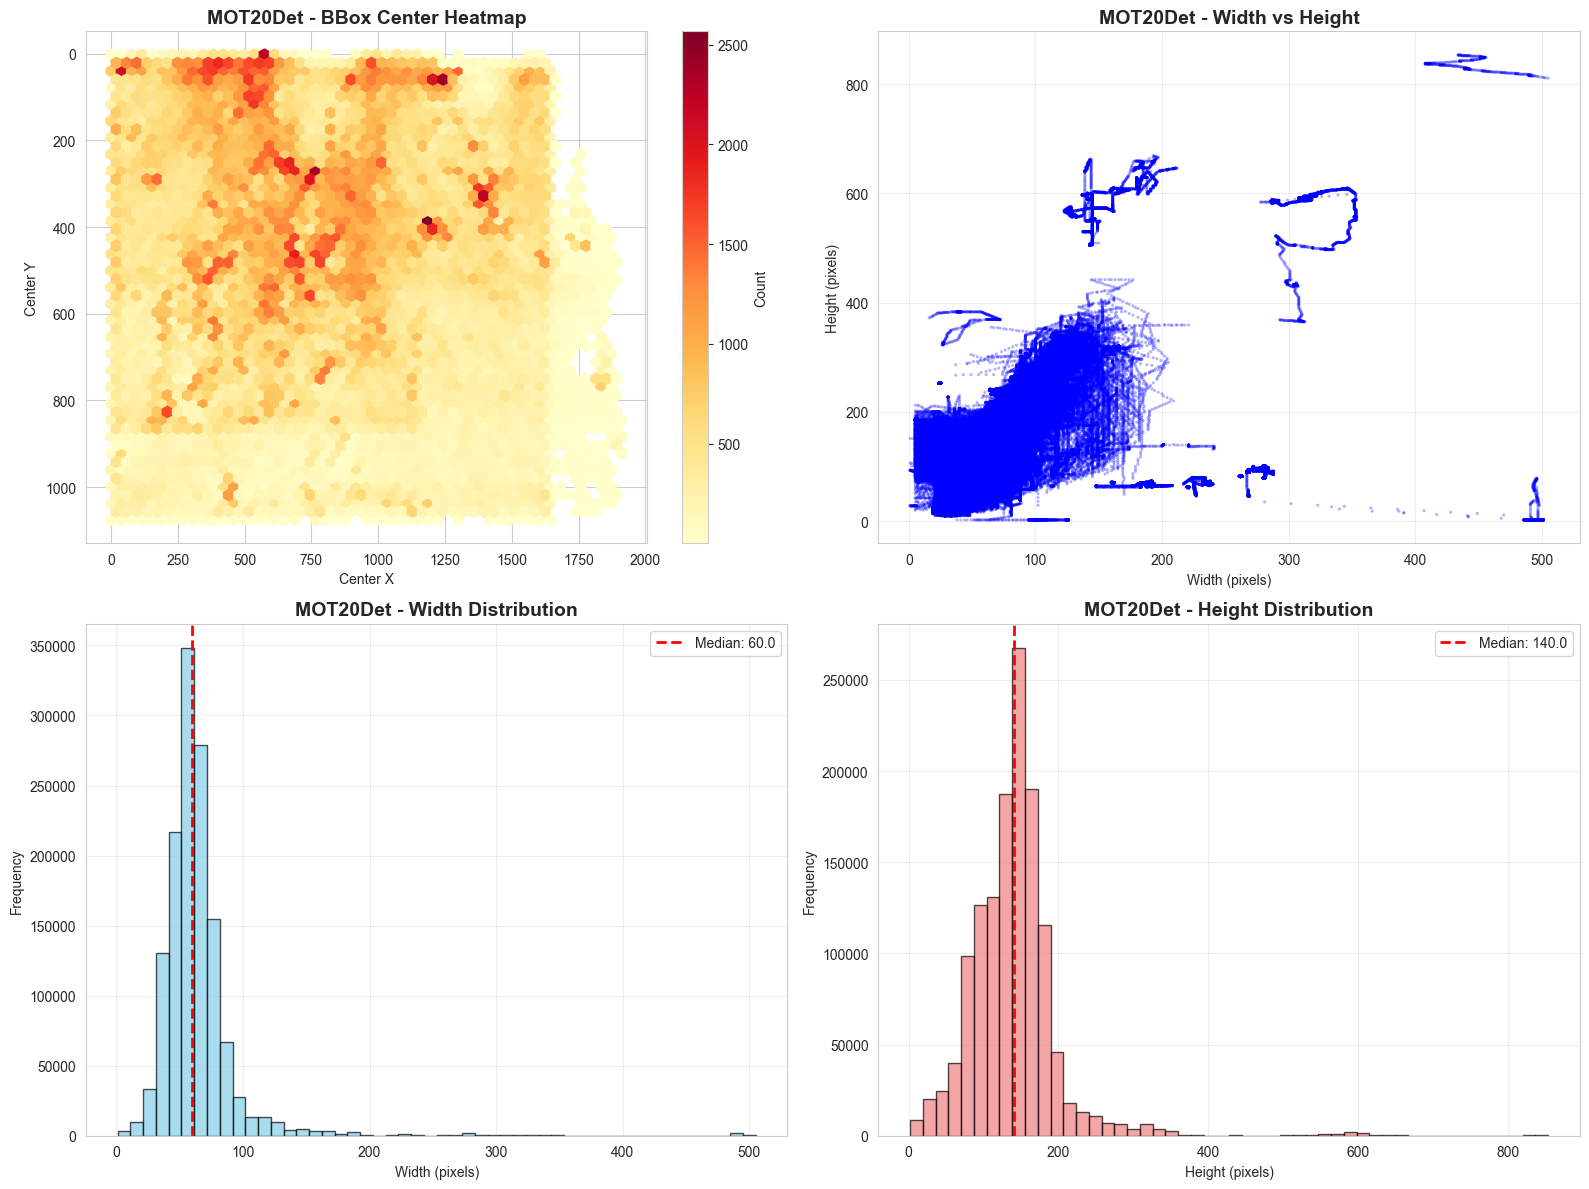

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# BBox center heatmap
axes[0, 0].hexbin(mot20_df['center_x'], mot20_df['center_y'], 
                  gridsize=50, cmap='YlOrRd', mincnt=1)
axes[0, 0].set_title('MOT20Det - BBox Center Heatmap', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Center X')
axes[0, 0].set_ylabel('Center Y')
axes[0, 0].invert_yaxis()
plt.colorbar(axes[0, 0].collections[0], ax=axes[0, 0], label='Count')

# Width vs Height scatter
axes[0, 1].scatter(mot20_df['bb_width'], mot20_df['bb_height'], 
                   alpha=0.3, s=5, c='blue', edgecolors='none')
axes[0, 1].set_title('MOT20Det - Width vs Height', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Width (pixels)')
axes[0, 1].set_ylabel('Height (pixels)')
axes[0, 1].grid(True, alpha=0.3)

# Width distribution
axes[1, 0].hist(mot20_df['bb_width'], bins=50, color='skyblue', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('MOT20Det - Width Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Width (pixels)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(mot20_df['bb_width'].median(), color='red', 
                   linestyle='--', linewidth=2, label=f'Median: {mot20_df["bb_width"].median():.1f}')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Height distribution
axes[1, 1].hist(mot20_df['bb_height'], bins=50, color='lightcoral', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('MOT20Det - Height Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Height (pixels)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(mot20_df['bb_height'].median(), color='red', 
                   linestyle='--', linewidth=2, label=f'Median: {mot20_df["bb_height"].median():.1f}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 1.6 MOT20Det Aspect Ratio Analysis

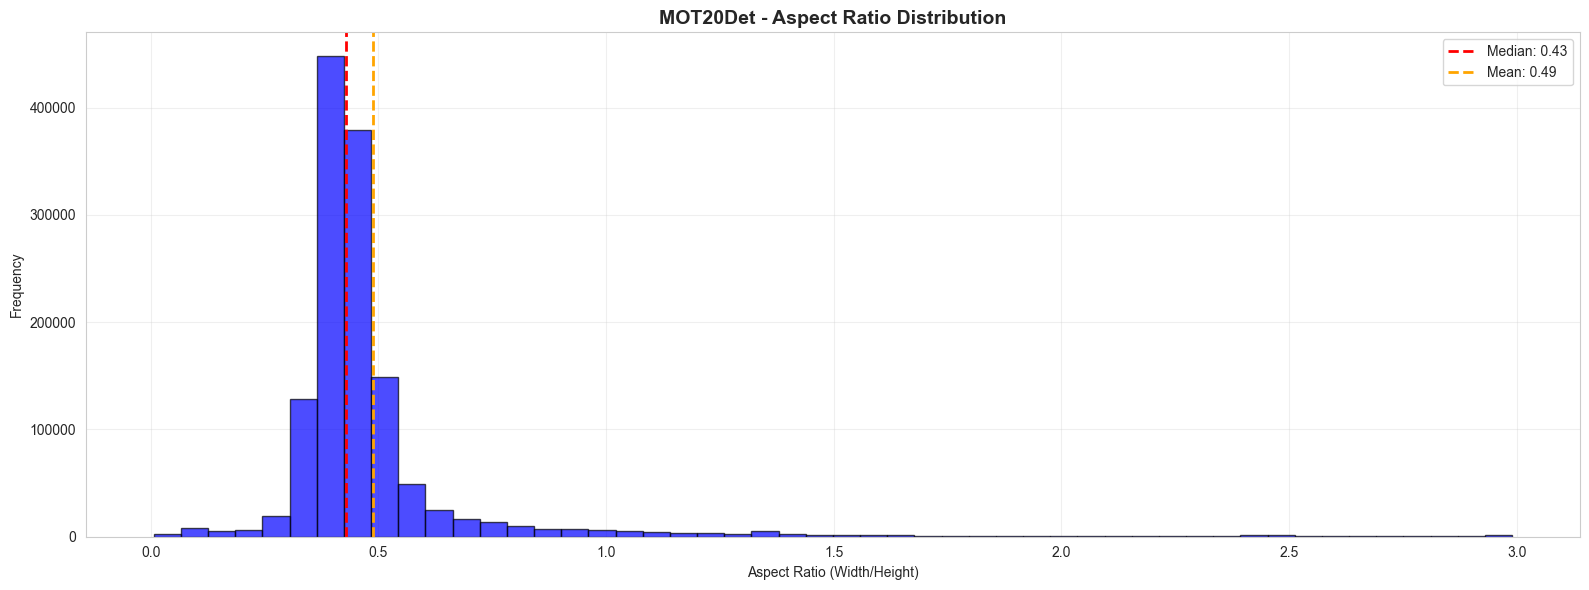

In [8]:
# Filter outliers for better visualization
mot20_filtered = mot20_df[(mot20_df['aspect_ratio'] > 0) & (mot20_df['aspect_ratio'] < 3)]

fig, ax = plt.subplots(1, 1, figsize=(16, 6))

# Aspect ratio distribution
ax.hist(mot20_filtered['aspect_ratio'], bins=50, color='blue', alpha=0.7, edgecolor='black')
ax.axvline(mot20_filtered['aspect_ratio'].median(), color='red', 
                linestyle='--', linewidth=2, label=f'Median: {mot20_filtered["aspect_ratio"].median():.2f}')
ax.axvline(mot20_filtered['aspect_ratio'].mean(), color='orange', 
                linestyle='--', linewidth=2, label=f'Mean: {mot20_filtered["aspect_ratio"].mean():.2f}')
ax.set_title('MOT20Det - Aspect Ratio Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Aspect Ratio (Width/Height)')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(True, alpha=0.3)

# Aspect ratio by occlusion level
mot20_filtered_occ = mot20_filtered.copy()
mot20_filtered_occ['occlusion_level'] = pd.cut(mot20_filtered_occ['visibility'], 
                                                bins=[0, 0.3, 0.6, 1.0], 
                                                labels=['Heavy', 'Moderate', 'Low/No'])
occlusion_order = ['Heavy', 'Moderate', 'Low/No']

plt.tight_layout()
plt.show()

---
# Part 2: WiderPerson Dataset Analysis
---

## 2.1 Load WiderPerson Dataset

In [9]:
def load_widerperson_annotations(data_dir='../data/WiderPerson'):
    """
    Load WiderPerson annotations.
    Format in annotation files: class_label, x1, y1, x2, y2
    First line contains number of annotations
    Classes: 1=pedestrian, 2=rider, 3=partially-visible, 4=ignore, 5=crowd
    """
    annotations = []
    data_path = Path(data_dir)
    ann_path = data_path / 'Annotations'
    
    class_names = {
        1: 'pedestrian',
        2: 'rider',
        3: 'partially-visible',
        4: 'ignore',
        5: 'crowd'
    }
    
    # Load splits
    for split_name in ['train', 'val', 'test']:
        split_file = data_path / f'{split_name}.txt'
        if not split_file.exists():
            continue
            
        with open(split_file, 'r') as f:
            image_ids = [line.strip() for line in f]
        
        for img_id in image_ids:
            ann_file = ann_path / f'{img_id}.jpg.txt'
            if ann_file.exists():
                with open(ann_file, 'r') as f:
                    lines = f.readlines()
                    num_objects = int(lines[0].strip())
                    
                    for line in lines[1:num_objects+1]:
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            class_label, x1, y1, x2, y2 = map(int, parts[:5])
                            annotations.append({
                                'image_id': img_id,
                                'class': class_label,
                                'class_name': class_names.get(class_label, 'unknown'),
                                'x1': x1,
                                'y1': y1,
                                'x2': x2,
                                'y2': y2,
                                'bb_width': x2 - x1,
                                'bb_height': y2 - y1,
                                'split': split_name
                            })
    
    return pd.DataFrame(annotations)

wider_df = load_widerperson_annotations()

# Calculate additional metrics
wider_df['center_x'] = (wider_df['x1'] + wider_df['x2']) / 2
wider_df['center_y'] = (wider_df['y1'] + wider_df['y2']) / 2
wider_df['aspect_ratio'] = wider_df['bb_width'] / wider_df['bb_height']
wider_df['area'] = wider_df['bb_width'] * wider_df['bb_height']

print(f"WiderPerson Total annotations: {len(wider_df):,}")
print(f"WiderPerson Images: {wider_df['image_id'].nunique():,}")
print(f"WiderPerson Splits: {wider_df['split'].value_counts().to_dict()}")
wider_df.head()

WiderPerson Total annotations: 273,475
WiderPerson Images: 9,000
WiderPerson Splits: {'train': 245052, 'val': 28423}


,image_id,class,class_name,x1,y1,x2,y2,bb_width,bb_height,split,center_x,center_y,aspect_ratio,area
0,000040,1,pedestrian,45,235,79,318,34,83,train,62.0,276.5,0.409639,2822
1,000040,1,pedestrian,60,209,120,356,60,147,train,90.0,282.5,0.408163,8820
2,000040,1,pedestrian,119,214,168,336,49,122,train,143.5,275.0,0.401639,5978
3,000040,1,pedestrian,94,220,136,326,42,106,train,115.0,273.0,0.396226,4452
4,000040,1,pedestrian,213,201,287,381,74,180,train,250.0,291.0,0.411111,13320


## 2.2 WiderPerson Class Distribution

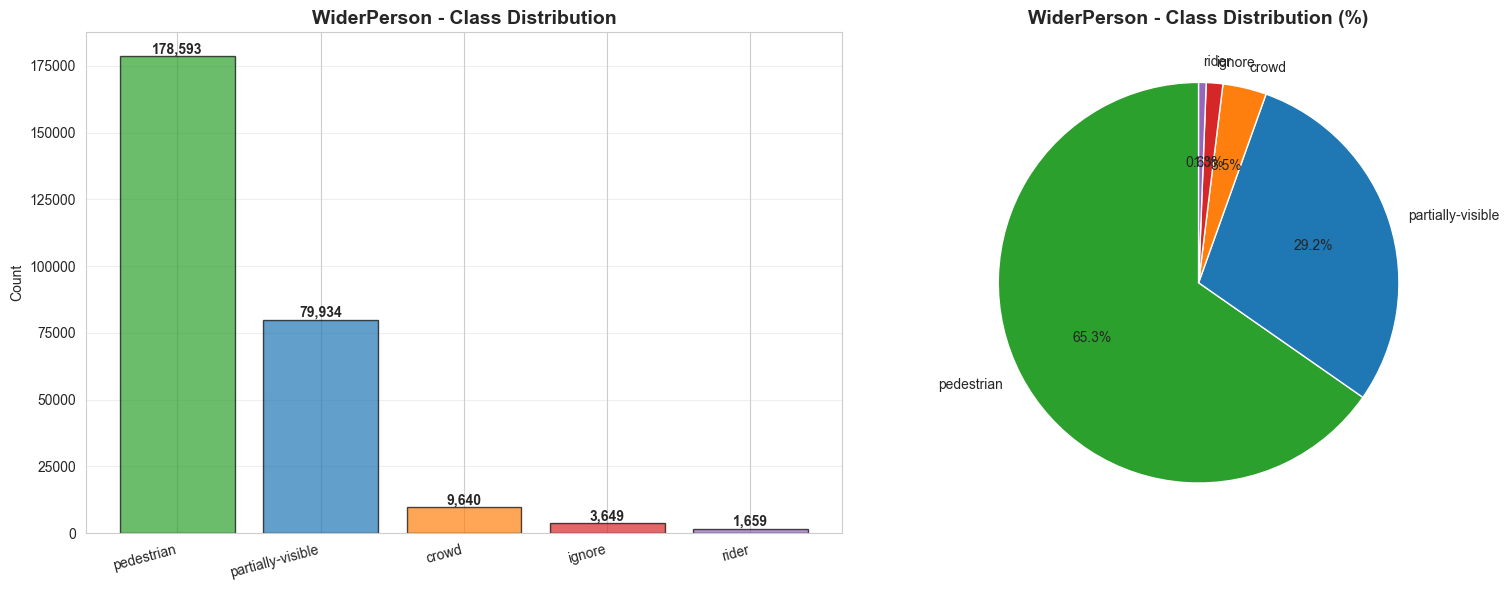

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Class distribution bar chart
class_counts = wider_df['class_name'].value_counts()
colors = ['#2ca02c', '#1f77b4', '#ff7f0e', '#d62728', '#9467bd']
axes[0].bar(range(len(class_counts)), class_counts.values, 
            color=colors[:len(class_counts)], alpha=0.7, edgecolor='black')
axes[0].set_xticks(range(len(class_counts)))
axes[0].set_xticklabels(class_counts.index, rotation=15, ha='right')
axes[0].set_title('WiderPerson - Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Class distribution pie chart
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=colors[:len(class_counts)], startangle=90)
axes[1].set_title('WiderPerson - Class Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 2.3 WiderPerson Occlusion Analysis

In [11]:
# Analyze occlusion through class labels
# Class 1 (pedestrian) and 2 (rider) are fully visible
# Class 3 (partially-visible) represents occlusion
wider_df['occlusion_category'] = wider_df['class_name'].apply(
    lambda x: 'Occluded/Partial' if x == 'partially-visible' 
    else ('Crowd' if x == 'crowd' 
          else ('Ignore' if x == 'ignore' 
                else 'Fully Visible'))
)

print("Occlusion Analysis:")
print(wider_df['occlusion_category'].value_counts())
print(f"\nOcclusion rate: {(wider_df['class_name'] == 'partially-visible').sum() / len(wider_df) * 100:.2f}%")

Occlusion Analysis:
occlusion_category
Fully Visible       180252
Occluded/Partial     79934
Crowd                 9640
Ignore                3649
Name: count, dtype: int64

Occlusion rate: 29.23%


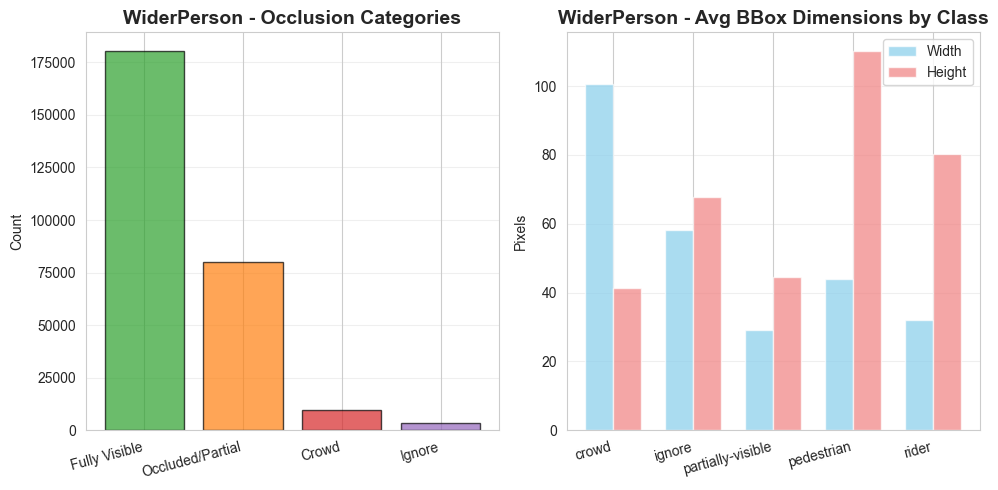

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Occlusion categories
occ_counts = wider_df['occlusion_category'].value_counts()
axes = axes.ravel()

axes[0].bar(range(len(occ_counts)), occ_counts.values, 
               color=['#2ca02c', '#ff7f0e', '#d62728', '#9467bd'][:len(occ_counts)], 
               alpha=0.7, edgecolor='black')
axes[0].set_xticks(range(len(occ_counts)))
axes[0].set_xticklabels(occ_counts.index, rotation=15, ha='right')
axes[0].set_title('WiderPerson - Occlusion Categories', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3, axis='y')

# Average bbox dimensions by class
class_dims = wider_df.groupby('class_name')[['bb_width', 'bb_height']].mean()
x_pos = np.arange(len(class_dims))
width = 0.35
axes[1].bar(x_pos - width/2, class_dims['bb_width'], width, label='Width', alpha=0.7, color='skyblue')
axes[1].bar(x_pos + width/2, class_dims['bb_height'], width, label='Height', alpha=0.7, color='lightcoral')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(class_dims.index, rotation=15, ha='right')
axes[1].set_title('WiderPerson - Avg BBox Dimensions by Class', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Pixels')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 2.4 WiderPerson Bounding Box Analysis

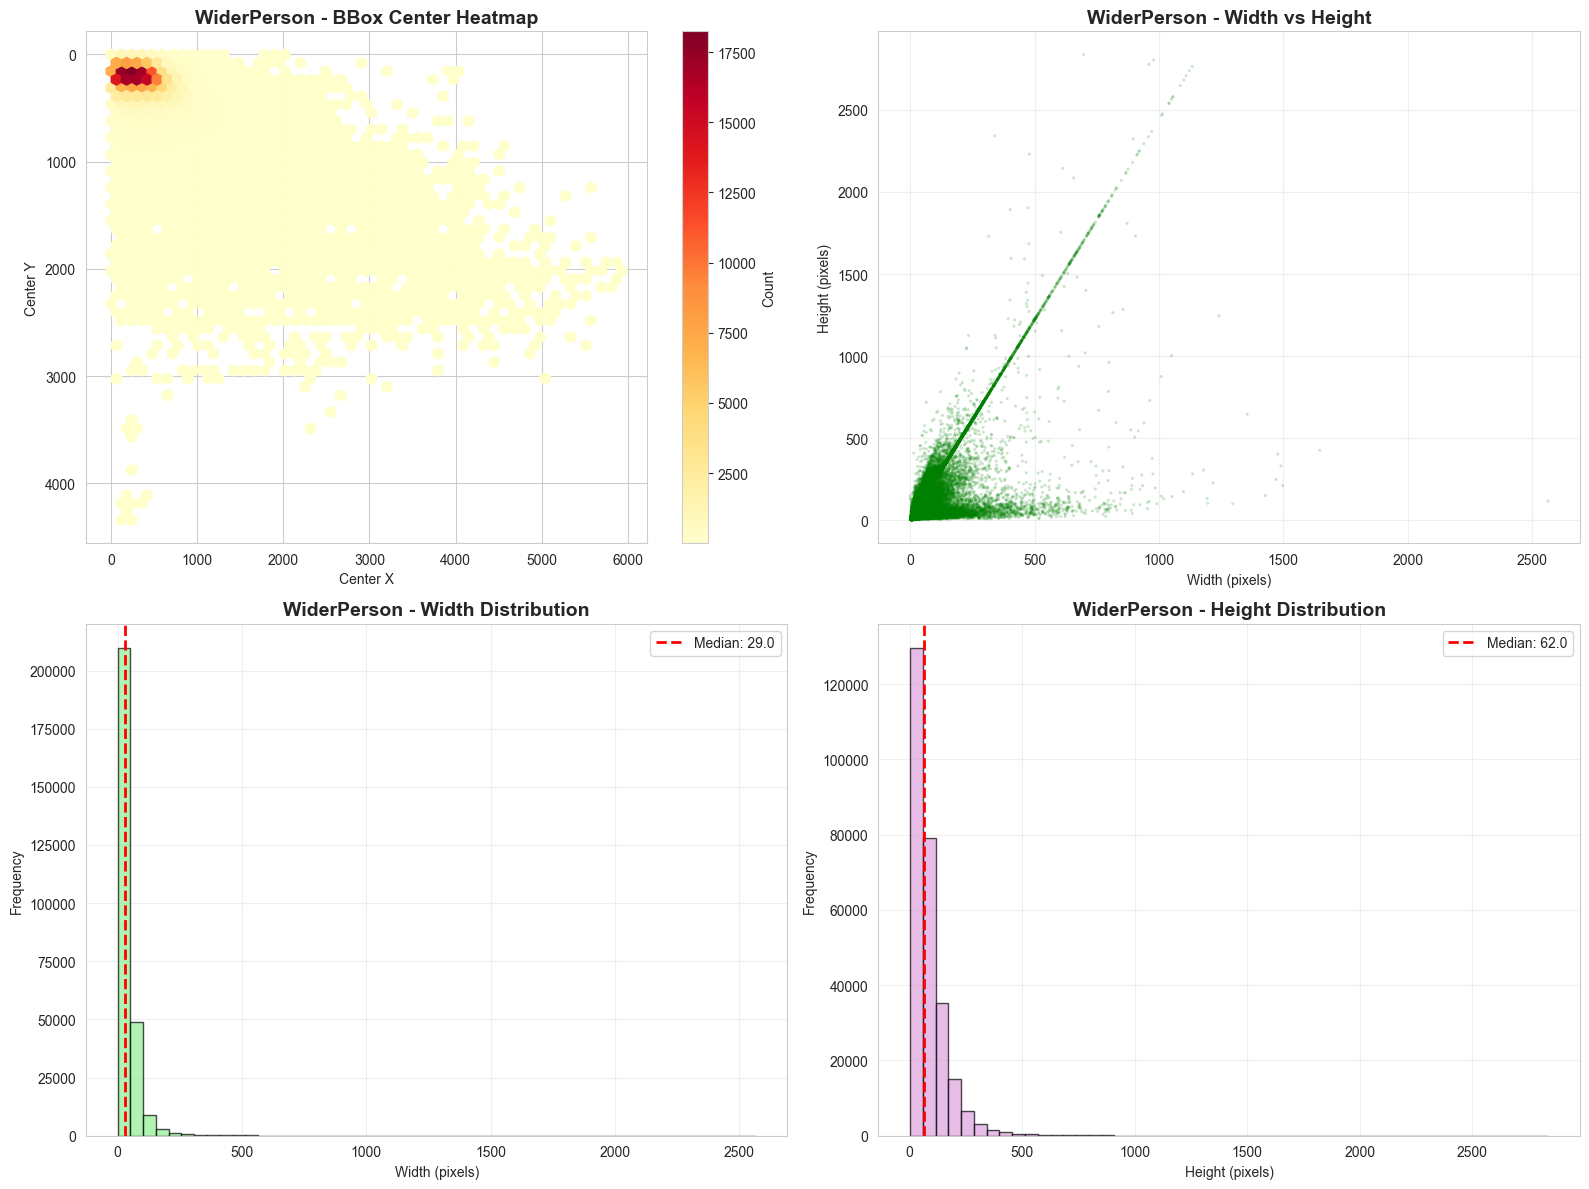

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# BBox center heatmap
axes[0, 0].hexbin(wider_df['center_x'], wider_df['center_y'], 
                  gridsize=50, cmap='YlOrRd', mincnt=1)
axes[0, 0].set_title('WiderPerson - BBox Center Heatmap', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Center X')
axes[0, 0].set_ylabel('Center Y')
axes[0, 0].invert_yaxis()
plt.colorbar(axes[0, 0].collections[0], ax=axes[0, 0], label='Count')

# Width vs Height scatter
axes[0, 1].scatter(wider_df['bb_width'], wider_df['bb_height'], 
                   alpha=0.2, s=5, c='green', edgecolors='none')
axes[0, 1].set_title('WiderPerson - Width vs Height', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Width (pixels)')
axes[0, 1].set_ylabel('Height (pixels)')
axes[0, 1].grid(True, alpha=0.3)

# Width distribution
axes[1, 0].hist(wider_df['bb_width'], bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('WiderPerson - Width Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Width (pixels)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(wider_df['bb_width'].median(), color='red', 
                   linestyle='--', linewidth=2, label=f'Median: {wider_df["bb_width"].median():.1f}')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Height distribution
axes[1, 1].hist(wider_df['bb_height'], bins=50, color='plum', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('WiderPerson - Height Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Height (pixels)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(wider_df['bb_height'].median(), color='red', 
                   linestyle='--', linewidth=2, label=f'Median: {wider_df["bb_height"].median():.1f}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2.5 WiderPerson Aspect Ratio Analysis

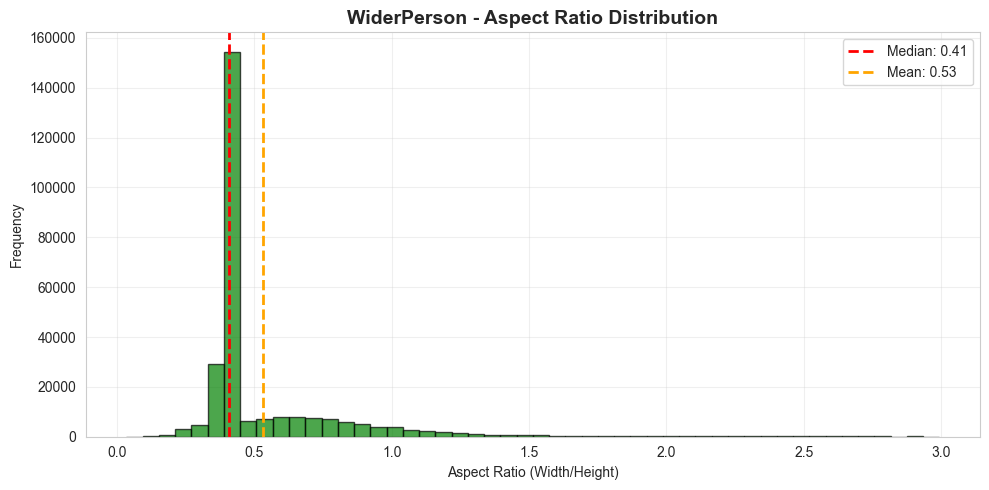

In [14]:
# Filter outliers for better visualization
wider_filtered = wider_df[(wider_df['aspect_ratio'] > 0) & (wider_df['aspect_ratio'] < 3)]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Aspect ratio distribution
ax.hist(wider_filtered['aspect_ratio'], bins=50, color='green', alpha=0.7, edgecolor='black')
ax.axvline(wider_filtered['aspect_ratio'].median(), color='red', 
                linestyle='--', linewidth=2, label=f'Median: {wider_filtered["aspect_ratio"].median():.2f}')
ax.axvline(wider_filtered['aspect_ratio'].mean(), color='orange', 
                linestyle='--', linewidth=2, label=f'Mean: {wider_filtered["aspect_ratio"].mean():.2f}')
ax.set_title('WiderPerson - Aspect Ratio Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Aspect Ratio (Width/Height)')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2.6 WiderPerson Data Split Analysis

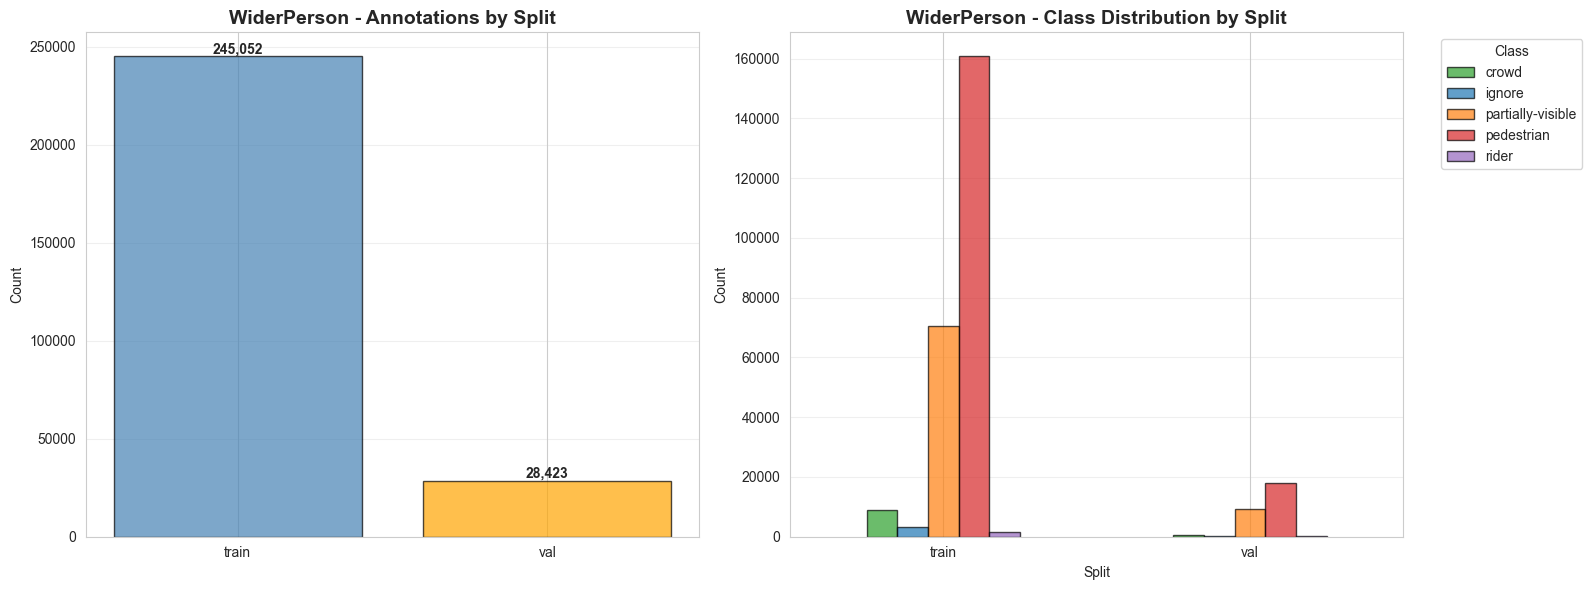

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Split distribution
split_counts = wider_df['split'].value_counts()
axes[0].bar(range(len(split_counts)), split_counts.values, 
            color=['steelblue', 'orange', 'green'][:len(split_counts)], alpha=0.7, edgecolor='black')
axes[0].set_xticks(range(len(split_counts)))
axes[0].set_xticklabels(split_counts.index)
axes[0].set_title('WiderPerson - Annotations by Split', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(split_counts.values):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Class distribution by split
split_class = wider_df.groupby(['split', 'class_name']).size().unstack(fill_value=0)
split_class.plot(kind='bar', ax=axes[1], color=colors, alpha=0.7, edgecolor='black')
axes[1].set_title('WiderPerson - Class Distribution by Split', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Split')
axes[1].set_ylabel('Count')
axes[1].legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()